## **HTRU2 Data Set**

#### Описание данных - https://archive.ics.uci.edu/ml/datasets/HTRU2

### Домашнее задание

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

### Data Set Information:

HTRU2 is a data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey (South) [1].

Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter (see [2] for more uses).

As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars
rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes.

Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation (see [2] for an introduction to pulsar astrophysics to find out why). Thus a potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find.

Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. Classification systems in particular are being widely adopted,
(see [4,5,6,7,8,9]) which treat the candidate data sets as binary classification problems. Here the legitimate pulsar examples are a minority positive class, and spurious examples the majority negative class. At present multi-class labels are unavailable, given the costs associated with data annotation.

The data set shared here contains 16,259 spurious examples caused by RFI/noise, and 1,639 real pulsar examples. These examples have all been checked by human annotators.

The data is presented in two formats: CSV and ARFF (used by the WEKA data mining tool). Candidates are stored in both files in separate rows. Each row lists the variables first, and the class label is the final entry. The class labels used are 0 (negative) and 1 (positive).

Please note that the data contains no positional information or other astronomical details. It is simply feature data extracted from candidate files using the PulsarFeatureLab tool (see [10]).

### Attribute Information:

Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency (see [3] for more details). The remaining four variables are similarly obtained from the DM-SNR curve (again see [3] for more details). These are summarised below:

1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.
9. Class

HTRU 2 Summary  
17,898 total examples.  
1,639 positive examples.  
16,259 negative examples.  

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72,5% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Пути к директориям и файлам

In [7]:
TRAIN_DATASET_PATH = './HTRU2/HTRU_2.csv'

### Загрузка данных

In [8]:
data = pd.read_csv(TRAIN_DATASET_PATH)

### Изучение датасета

In [9]:
data.head()

,140.5625,55.68378214,-0.234571412,-0.699648398,3.199832776,19.11042633,7.975531794,74.24222492,0
0,102.50781,58.88243,0.46532,-0.51509,1.67726,14.86015,10.57649,127.39358,0
1,103.01562,39.34165,0.32333,1.05116,3.12124,21.74467,7.73582,63.17191,0
2,136.75000,57.17845,-0.06841,-0.63624,3.64298,20.95928,6.89650,53.59366,0
3,88.72656,40.67223,0.60087,1.12349,1.17893,11.46872,14.26957,252.56731,0
4,93.57031,46.69811,0.53190,0.41672,1.63629,14.54507,10.62175,131.39400,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17897 entries, 0 to 17896
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   140.5625      17897 non-null  float64
 1   55.68378214   17897 non-null  float64
 2   -0.234571412  17897 non-null  float64
 3   -0.699648398  17897 non-null  float64
 4   3.199832776   17897 non-null  float64
 5   19.11042633   17897 non-null  float64
 6   7.975531794   17897 non-null  float64
 7   74.24222492   17897 non-null  float64
 8   0             17897 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [11]:
data.rename(columns={'140.5625': 'Mean of the integrated profile',
                     '55.68378214': 'Standard deviation of the integrated profile',
                     '-0.234571412': 'Excess kurtosis of the integrated profile',
                     '-0.699648398': 'Skewness of the integrated profile',
                     '3.199832776': 'Mean of the DM-SNR curve',
                     '19.11042633': 'Standard deviation of the DM-SNR curve',
                     '7.975531794': 'Excess kurtosis of the DM-SNR curv',
                     '74.24222492': 'Skewness of the DM-SNR curve',
                     '0': 'target'}, inplace=True)
# 1. Mean of the integrated profile - Среднее значение интегрированного профиля
# 2. Standard deviation of the integrated profile - Стандартное отклонение интегрированного профиля
# 3. Excess kurtosis of the integrated profile - Чрезмерный эксцесс интегрированного профиля
# 4. Skewness of the integrated profile - Асимметрия интегрированного профиля
# 5. Mean of the DM-SNR curve - Среднее значение кривой DM-SNR
# 6. Standard deviation of the DM-SNR curve - Стандартное отклонение кривой DM-SNR
# 7. Excess kurtosis of the DM-SNR curve - Избыточный эксцесс кривой DM-SNR
# 8. Skewness of the DM-SNR curve - Асимметрия кривой DM-SNR.
# 9. target - Целевая переменная.

In [12]:
data.tail()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curv,Skewness of the DM-SNR curve,target
17892,136.42969,59.84742,-0.18785,-0.73812,1.29682,12.16606,15.45026,285.93102,0
17893,122.55469,49.48561,0.12798,0.32306,16.40970,44.62689,2.94524,8.29709,0
17894,119.33594,59.93594,0.15936,-0.74303,21.43060,58.87200,2.49952,4.59517,0
17895,114.50781,53.90240,0.20116,-0.02479,1.94649,13.38173,10.00797,134.23891,0
17896,57.06250,85.79734,1.40639,0.08952,188.30602,64.71256,-1.59753,1.42948,0


data.info()

In [13]:
print(data.shape)

(17897, 9)


### Количественные переменные

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,17897.00000,111.07832,25.65271,5.81250,100.92969,115.07812,127.08594,192.61719
Standard deviation of the integrated profile,17897.00000,46.54902,6.84304,24.77204,42.37543,46.94644,51.02289,98.77891
Excess kurtosis of the integrated profile,17897.00000,0.47790,1.06406,-1.87601,0.02711,0.22324,0.47335,8.06952
Skewness of the integrated profile,17897.00000,1.77042,6.16806,-1.79189,-0.18853,0.19874,0.92821,68.10162
Mean of the DM-SNR curve,17897.00000,12.61493,29.47364,0.21321,1.92308,2.80184,5.46488,223.39214
Standard deviation of the DM-SNR curve,17897.00000,26.32692,19.47104,7.37043,14.43733,18.45998,28.42815,110.64221
Excess kurtosis of the DM-SNR curv,17897.00000,8.30357,4.50622,-3.13927,5.78149,8.43387,10.70297,34.53984
Skewness of the DM-SNR curve,17897.00000,104.85942,106.51727,-1.97698,34.95712,83.06900,139.31090,1191.00084
target,17897.00000,0.09158,0.28844,0.00000,0.00000,0.00000,0.00000,1.00000


### Целевая переменная

In [15]:
data['target'].value_counts()

0    16258
1     1639
Name: target, dtype: int64

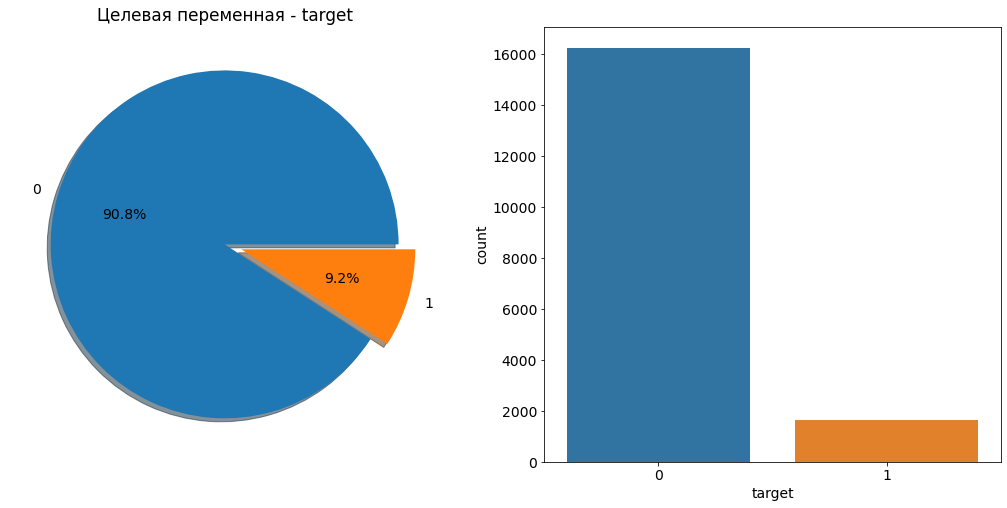

In [16]:
f, ax=plt.subplots(1, 2, figsize=(18, 8))
data['target'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Целевая переменная - target')
ax[0].set_ylabel('')
sns.countplot('target', data=data, ax=ax[1])
plt.show()

###  Обработка выбросов и пропусков

In [17]:
data.isnull().sum()

Mean of the integrated profile                  0
Standard deviation of the integrated profile    0
Excess kurtosis of the integrated profile       0
Skewness of the integrated profile              0
Mean of the DM-SNR curve                        0
Standard deviation of the DM-SNR curve          0
Excess kurtosis of the DM-SNR curv              0
Skewness of the DM-SNR curve                    0
target                                          0
dtype: int64

### Корреляция признаков

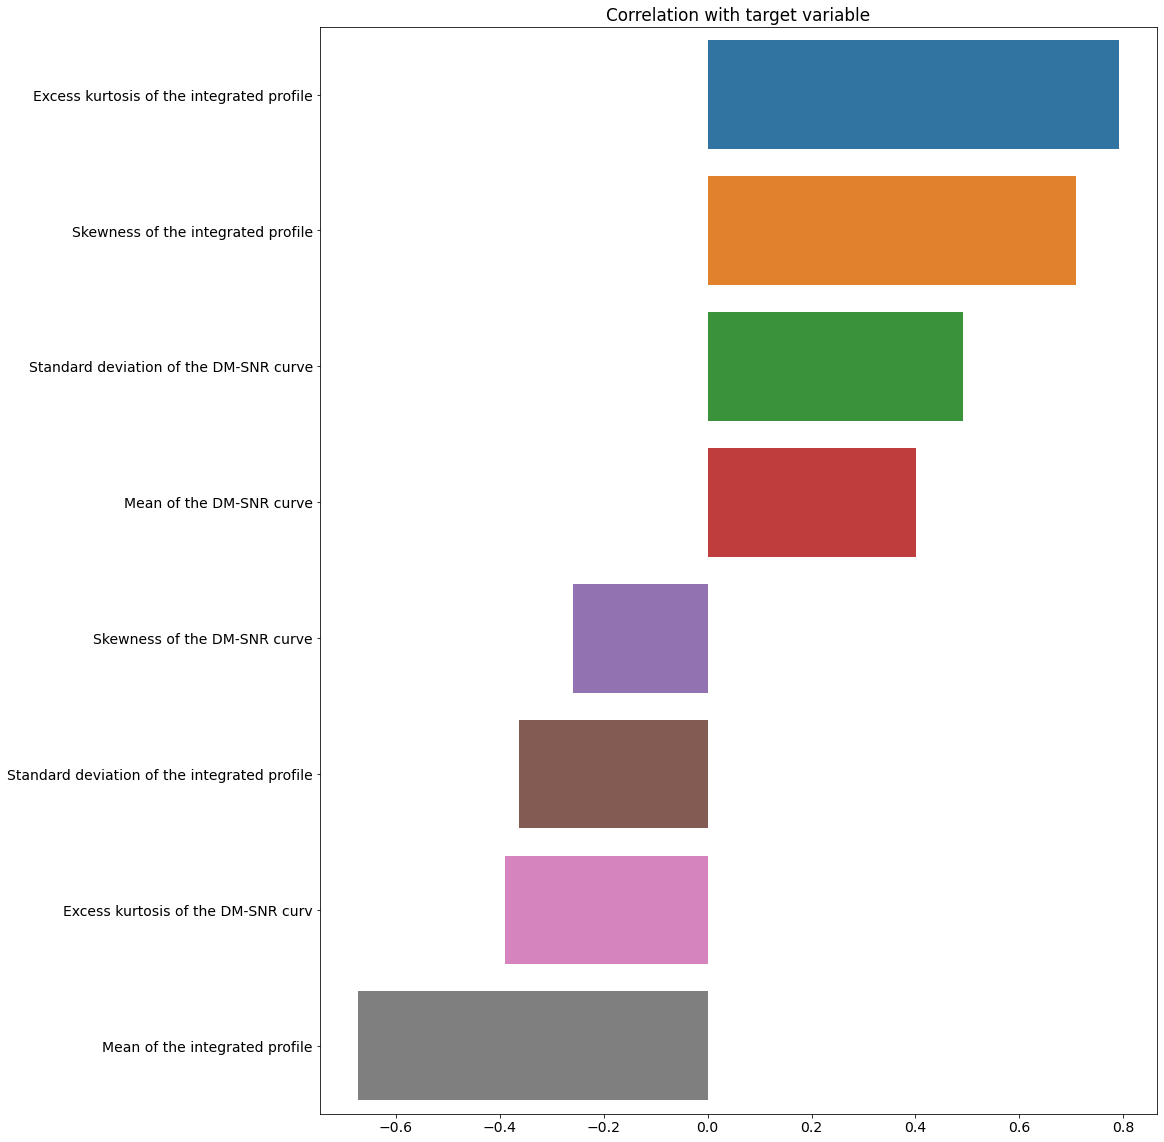

In [18]:
TARGET_NAME = 'target'

corr_with_target = data.corr()[TARGET_NAME].sort_values(ascending=False)[1:]
plt.figure(figsize=(15, 20))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

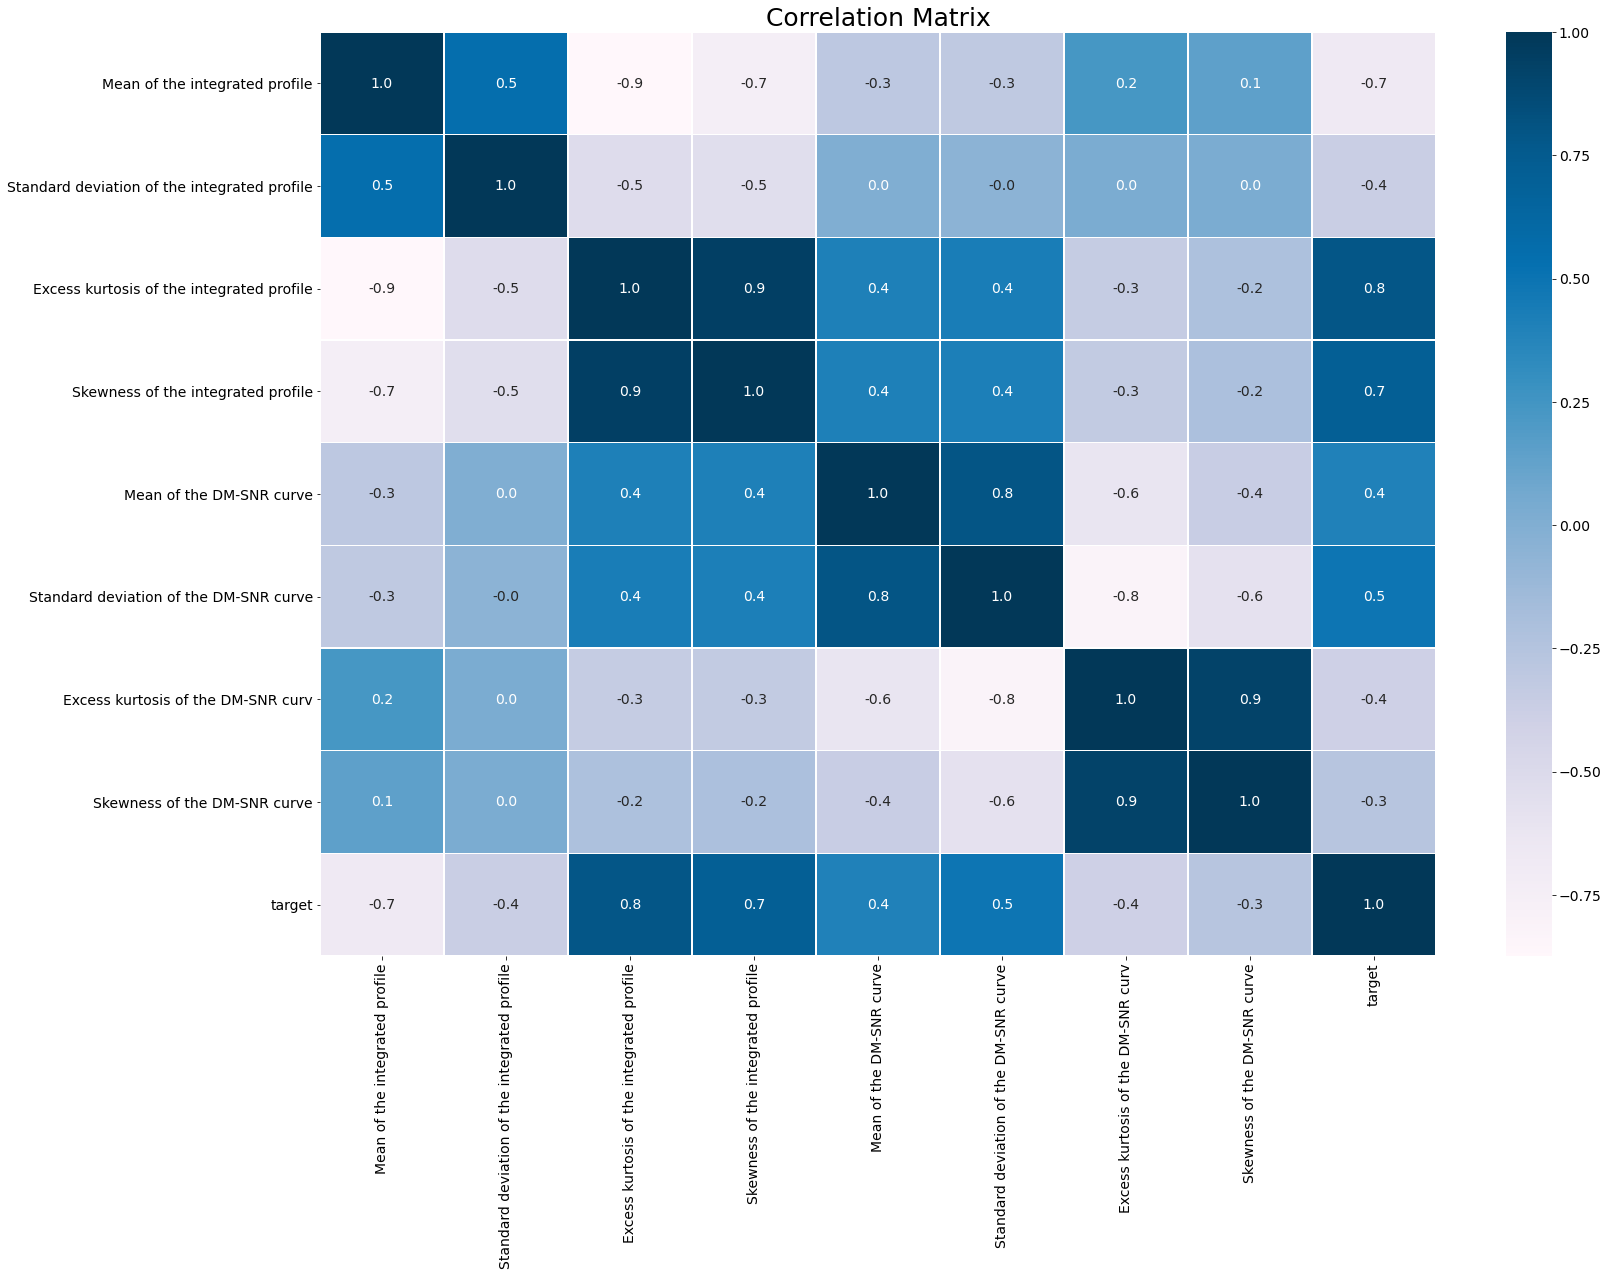

In [19]:
# Correlation Matrix
f, ax = plt.subplots(figsize = [25, 17])
sns.heatmap(data.corr(), annot=True, fmt='.1f', linewidths=.5, ax=ax, cmap = 'PuBu' )
ax.set_title('Correlation Matrix', fontsize=25)
plt.show()

### Feature engineering

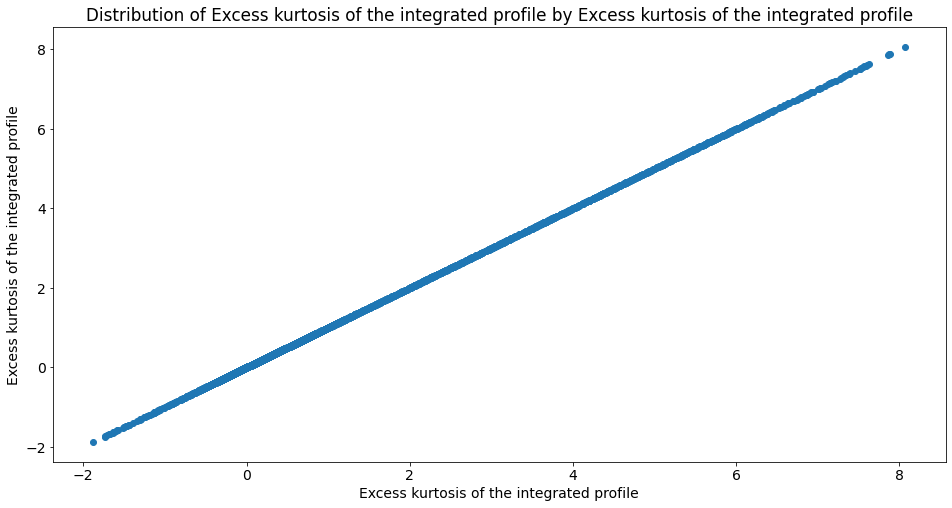

In [20]:
plt.figure(figsize = (16, 8))
plt.scatter(data['Excess kurtosis of the integrated profile'], data['Excess kurtosis of the integrated profile'])
plt.ylabel('Excess kurtosis of the integrated profile')
plt.xlabel('Excess kurtosis of the integrated profile')
plt.title('Distribution of Excess kurtosis of the integrated profile by Excess kurtosis of the integrated profile')
plt.show();

In [21]:
data['Excess kurtosis of the integrated profile'].describe([.01,.1,.25,.5,.75,.9,.91,.92,.93,.94,.95,.96])

count   17897.00000
mean        0.47790
std         1.06406
min        -1.87601
1%         -0.47919
10%        -0.13319
25%         0.02711
50%         0.22324
75%         0.47335
90%         0.89182
91%         1.01816
92%         1.21621
93%         1.61137
94%         2.13656
95%         2.70675
96%         3.34544
max         8.06952
Name: Excess kurtosis of the integrated profile, dtype: float64

In [22]:
# # Уменьшение количества выбросов - \(o_O)/
# quantile_91 = data['Excess kurtosis of the integrated profile'].quantile(0.91)
# data.loc[data['Excess kurtosis of the integrated profile'] > quantile_91, 'Excess kurtosis of the integrated profile'] = quantile_91

### Подготовка признаков

In [23]:
X = pd.get_dummies(data)
X.drop('target', axis=1, inplace=True)
X.drop('Skewness of the integrated profile', axis=1, inplace=True)

y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.29)

### Первичный подбор стандартных моделей:

In [24]:
models = []

models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
models.append(('LGBMClassifier', LGBMClassifier()))
models.append(('LogisticRegression', LogisticRegression()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('XGBClassifier', XGBClassifier(silent=True)))

In [25]:
results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred_train  = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    TRAIN = f1_score(y_train, y_pred_train)
    Accuracy_scores = accuracy_score(y_test, y_pred_test)
    TEST = f1_score(y_test, y_pred_test)
    results.append((name, TRAIN, TEST, Accuracy_scores))
    
best_models = pd.DataFrame(results, columns = ['model', 'TRAIN - f1_score', 'TEST - f1_score', 'Accuracy_scores'])
best_models.sort_values('TEST - f1_score', ascending=False)

,model,TRAIN - f1_score,TEST - f1_score,Accuracy_scores
0,CatBoostClassifier,0.94932,0.89151,0.98054
6,XGBClassifier,0.98946,0.88722,0.97977
5,RandomForestClassifier,1.00000,0.88337,0.97919
3,LGBMClassifier,0.97979,0.88312,0.97919
1,ExtraTreesClassifier,1.00000,0.88017,0.97881
2,GradientBoostingClassifier,0.92356,0.87433,0.97746
4,LogisticRegression,0.87191,0.87004,0.97727


### Алгоритм - LGBMClassifier

In [26]:
%%time
model_lgbmc = LGBMClassifier(learning_rate=0.1111, n_estimators=155, max_depth=4)
model_lgbmc.fit(X_train, y_train)
y_pred_train  = model_lgbmc.predict(X_train)
y_pred_test = model_lgbmc.predict(X_test)
print('TRAIN - LGBMClassifier\n\n' + classification_report(y_train, y_pred_train))
print('TEST - LGBMClassifier\n\n' + classification_report(y_test, y_pred_test))
print(f'TRAIN - LGBMClassifier - {f1_score(y_train, y_pred_train)}')
print(f'TEST - LGBMClassifier - {f1_score(y_test, y_pred_test)}')

TRAIN - LGBMClassifier

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11556
           1       0.97      0.90      0.94      1150

    accuracy                           0.99     12706
   macro avg       0.98      0.95      0.97     12706
weighted avg       0.99      0.99      0.99     12706

TEST - LGBMClassifier

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4702
           1       0.93      0.83      0.88       489

    accuracy                           0.98      5191
   macro avg       0.95      0.91      0.93      5191
weighted avg       0.98      0.98      0.98      5191

TRAIN - LGBMClassifier - 0.9363431151241536
TEST - LGBMClassifier - 0.8759439050701188
Wall time: 269 ms


### Алгоритм - RandomForestClassifier

In [27]:
%%time
model_rfc = RandomForestClassifier(n_estimators=250, max_depth=16)
model_rfc.fit(X_train, y_train)
y_pred_train  = model_rfc.predict(X_train)
y_pred_test = model_rfc.predict(X_test)
print('TRAIN - LGBMClassifier\n\n' + classification_report(y_train, y_pred_train))
print('TEST - LGBMClassifier\n\n' + classification_report(y_test, y_pred_test))
print(f'TRAIN - LGBMClassifier - {f1_score(y_train, y_pred_train)}')
print(f'TEST - LGBMClassifier - {f1_score(y_test, y_pred_test)}')

TRAIN - LGBMClassifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11556
           1       1.00      0.97      0.99      1150

    accuracy                           1.00     12706
   macro avg       1.00      0.99      0.99     12706
weighted avg       1.00      1.00      1.00     12706

TEST - LGBMClassifier

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4702
           1       0.93      0.84      0.88       489

    accuracy                           0.98      5191
   macro avg       0.96      0.92      0.94      5191
weighted avg       0.98      0.98      0.98      5191

TRAIN - LGBMClassifier - 0.9863375936535919
TEST - LGBMClassifier - 0.8824163969795037
Wall time: 5.88 s


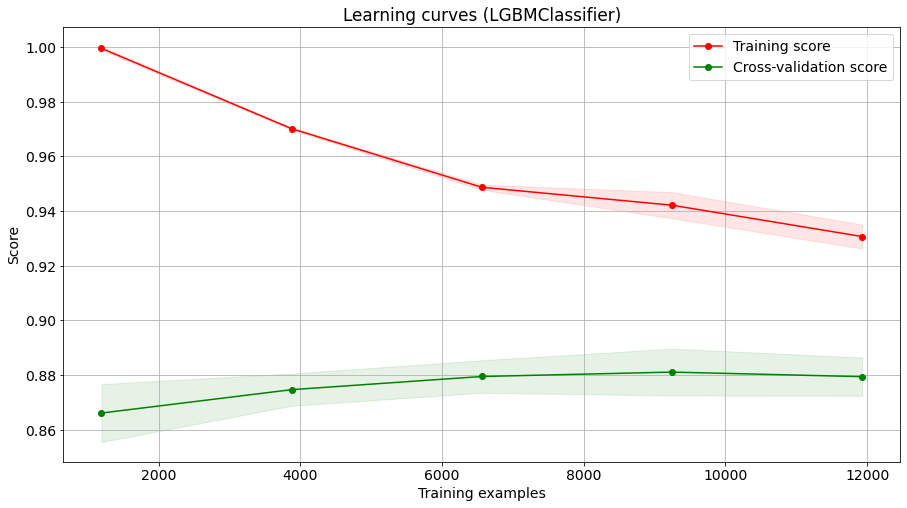

In [28]:
show_learning_curve_plot(model_lgbmc, X, y)

Confusion matrix, without normalization
[[4673   29]
 [  80  409]]


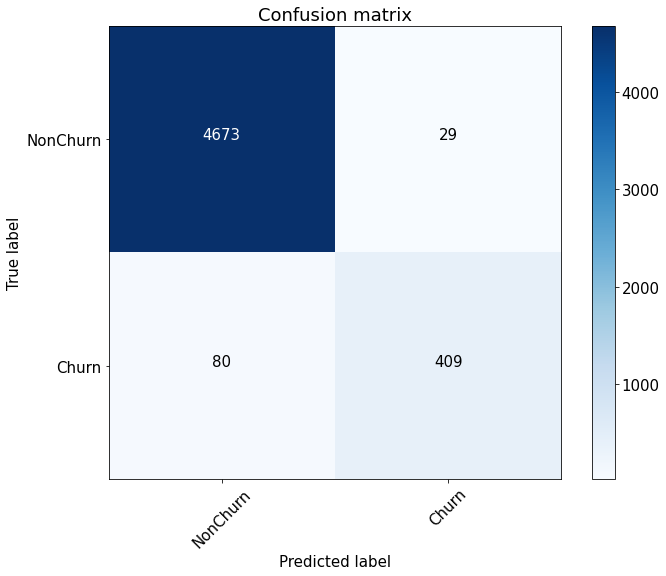

In [29]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

### SHAP

In [30]:
import shap

In [31]:
# load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(model_lgbmc)
shap_values = explainer.shap_values(X)

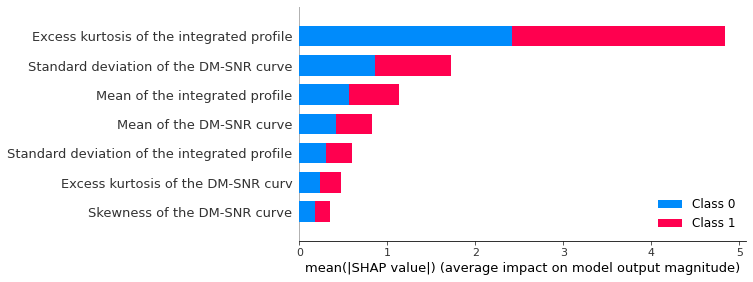

In [33]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, plot_type='bar')

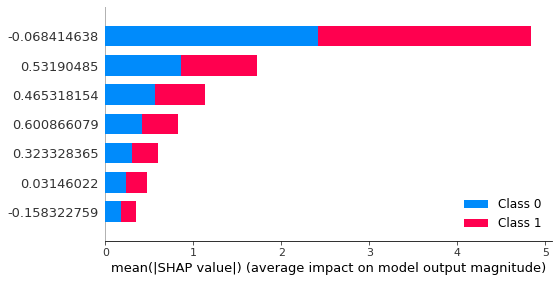

In [34]:
shap.summary_plot(shap_values, X['Excess kurtosis of the integrated profile'], plot_type='bar')

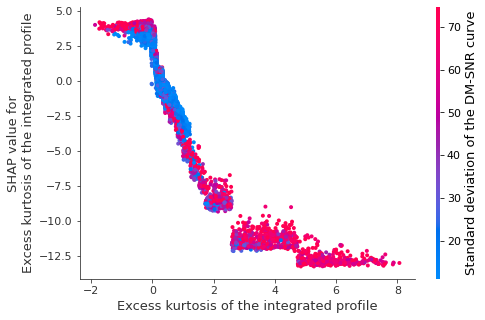

In [35]:
shap.dependence_plot('Excess kurtosis of the integrated profile', shap_values[0], X)

In [36]:
data['Excess kurtosis of the integrated profile'].describe([.01,.02,.03,.04,.05,.1,.11,.25,.5,.75,.9,.91,.92,.93,.94,.95,.96])

count   17897.00000
mean        0.47790
std         1.06406
min        -1.87601
1%         -0.47919
2%         -0.35522
3%         -0.29896
4%         -0.26234
5%         -0.23161
10%        -0.13319
11%        -0.11866
25%         0.02711
50%         0.22324
75%         0.47335
90%         0.89182
91%         1.01816
92%         1.21621
93%         1.61137
94%         2.13656
95%         2.70675
96%         3.34544
max         8.06952
Name: Excess kurtosis of the integrated profile, dtype: float64

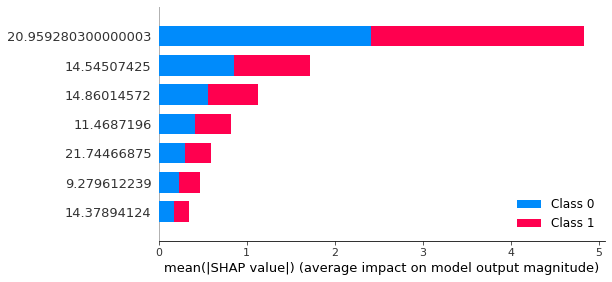

In [37]:
shap.summary_plot(shap_values, X['Standard deviation of the DM-SNR curve'], plot_type='bar')

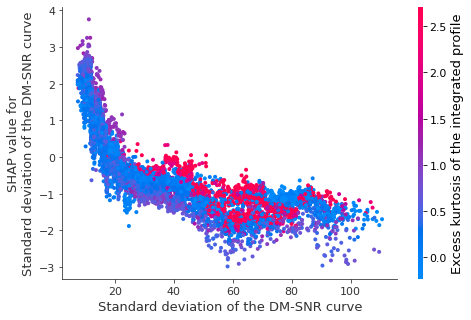

In [38]:
shap.dependence_plot('Standard deviation of the DM-SNR curve', shap_values[0], X)

In [39]:
data['Standard deviation of the DM-SNR curve'].describe([.01,.04,.06,.07,.1,.24,.25,.26,.27,.5,.598,.599,.623,.75,.9])

count   17897.00000
mean       26.32692
std        19.47104
min         7.37043
1%          9.30791
4%         10.75895
6%         11.32924
7%         11.57694
10%        12.13183
24%        14.29825
25%        14.43733
26%        14.56770
27%        14.71763
50%        18.45998
59.8%      20.94022
59.9%      20.96069
62.3%      21.74497
75%        28.42815
90%        59.08103
max       110.64221
Name: Standard deviation of the DM-SNR curve, dtype: float64

In [40]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X.iloc[0,:], link="logit")

In [41]:
# plot the SHAP values for the 117th observation 
shap.force_plot(explainer.expected_value[0], shap_values[0][117,:], X.iloc[117,:])